# Tutorial XI - Arena Seat Planning under Distancing Rules

Applied Optimization with Julia

# Introduction

Imagine you’re tasked with optimizing seating arrangements for a major
event venue during a pandemic. You need to balance safety with
efficiency, ensuring groups can enjoy the event while maintaining proper
distancing.

Your challenge is to:

1.  Place different-sized groups strategically
2.  Maintain safe distances between all attendees
3.  Maximize either revenue or total attendance
4.  Work around venue constraints and blocked seats

## The Venue Layout

Here’s our event venue’s seating arrangement, as we have used in the
lecture:

<figure>
<img src="https://images.byndsim.com/ao/ao_arena-empty_exercise.svg"
alt="Each white square represents an available seat, while grey squares are blocked" />
<figcaption aria-hidden="true">Each white square represents an available
seat, while grey squares are blocked</figcaption>
</figure>

## Group Types and Their Characteristics

We have different types of groups wanting to attend the event:

-   Singles (Type ‘a’): Solo attendees
-   Couples (Types ‘b’ and ‘c’): Two people travelling together
-   Small families (Types ‘d’ and ‘e’): Groups of four
-   Large families (Types ‘f’ and ‘g’): Groups of six

Each group type has:

-   A different ticket value (score)
-   Limited availability (how many such groups want tickets)
-   Space requirements (how many consecutive seats they need)

As we approach the end of the course, we’ll remove some previous
“guardrails” to give you more freedom in solving the problem.

> **Tip**
>
> Don’t worry, if you cannot solve everything by yourself. Try your best
> and ask for help if you need it!

# 1. Implement the Model

First, define all necessary sets, parameters, and variables to model the
problem in Julia. The seating area layout is shown below:

![](https://images.byndsim.com/ao/ao_arena-empty_exercise.svg)

## Distance Requirements

The following distancing rules must be maintained:

-   Minimum one empty seat between groups
-   One empty seat between rows
-   One empty seat diagonally
-   Maximum two groups per row
-   Grey seats are obstacles and cannot be used

> **Common Pitfalls**
>
> Watch out for the edge cases when implementing distancing
> constraints - especially around blocked seats!

## Define the Model

> **Note**
>
> The groups are given **differently than in the lecture**! Either
> adjust the data or the model, depending on what you think is easier.

In [1]:
using JuMP
using HiGHS

# Model
arena_model = Model(HiGHS.Optimizer)

# Sets
row_set = 1:10
col_set = 1:10

# Group data
groups = [
    "a",
    "b",
    "c",
    "d",
    "e",
    "f",
    "g"]
req_seats = Dict(
    "a" => 1,
    "b" => 2,
    "c" => 2,
    "d" => 4,
    "e" => 4,
    "f" => 6,
    "g" => 6)
scores = Dict(
    "a" => 1,
    "b" => 2,
    "c" => 4,
    "d" => 4,
    "e" => 5,
    "f" => 6,
    "g" => 12)
availability = Dict(
    "a" => 3,
    "b" => 2,
    "c" => 3,
    "d" => 5,
    "e" => 2,
    "f" => 1,
    "g" => 1)

# Blocked seats (coordinates [row, column])
blocked_seats = [
    (1, 1),(1, 2),(1,9),(1,10),
    (2, 1),(2, 10),
    (6, 5),(6,6),
    (7, 5),(7,6),
]

# Variables
@variable(arena_model, x[groups, row_set, col_set], Bin)

# Parameters
h = 1  # horizontal safety distance
b = 1  # vertical safety distance
p = 2  # max groups per row

# Objective
@objective(arena_model, Max, sum(scores[g] * x[g,r,c] for g in groups, r in row_set, c in col_set if c<=maximum(col_set)-req_seats[g]+1))

# Constraints
# Each group can only be assigned once
@constraint(arena_model, [g in groups],
    sum(x[g,r,c] for r in row_set, c in col_set) <= availability[g])

# Maximum groups per row
@constraint(arena_model, [r in row_set],
    sum(x[g,r,c] for g in groups, c in col_set) <= p)

# Horizontal and vertical social distancing
@constraint(arena_model, [r in row_set, c in col_set],
    sum(x[g,rr,cc] for g in groups,
        rr in max(1,r-b):r,
        cc in max(1,c-req_seats[g]+1-h):c) <= 1)

# Constraints to prevent assignments to blocked seats
@constraint(arena_model, [g in groups, (r,c) in blocked_seats],
    sum(x[g,r,cc] for cc in max(1,c-req_seats[g]+1):c) == 0)

# Solve the model
optimize!(arena_model)

Running HiGHS 1.8.1 (git hash: 4a7f24ac6): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [1e+00, 1e+00]
  Cost   [1e+00, 1e+01]
  Bound  [1e+00, 1e+00]
  RHS    [1e+00, 5e+00]
Presolving model
112 rows, 422 cols, 3861 nonzeros  0s
91 rows, 326 cols, 2644 nonzeros  0s
Objective function is integral with scale 1

Solving MIP model with:
   91 rows
   326 cols (326 binary, 0 integer, 0 implied int., 0 continuous)
   2644 nonzeros

Src: B => Branching; C => Central rounding; F => Feasibility pump; H => Heuristic; L => Sub-MIP;
     P => Empty MIP; R => Randomized rounding; S => Solve LP; T => Evaluate node; U => Unbounded;
     z => Trivial zero; l => Trivial lower; u => Trivial upper; p => Trivial point

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
Src  Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Confl. | LpIters     Time

 z       0  

## Visualization

To test your solution, visualize it with a plot in Julia. The
visualization is a great tool to <span class="highlight">check if your
solution is correct</span>. We figure it is likely, that you **won’t
have an applicable solution** after the first round, even if your model
is working correctly. <span class="highlight">If everything works from
the start, great!</span>

Blocked seat in 1,1
Blocked seat in 1,2
Group f in 1,3
Group f in 1,4
Group f in 1,5
Group f in 1,6
Group f in 1,7
Group f in 1,8
Blocked seat in 1,9
Blocked seat in 1,10
Blocked seat in 2,1
Blocked seat in 2,10
Group e in 3,4
Group e in 3,5
Group e in 3,6
Group e in 3,7
Group b in 3,9
Group b in 3,10
Group c in 4,1
Group c in 4,2
Group c in 5,4
Group c in 5,5
Group e in 5,7
Group e in 5,8
Group e in 5,9
Group e in 5,10
Group b in 6,1
Group b in 6,2
Blocked seat in 6,5
Blocked seat in 6,6
Blocked seat in 7,5
Blocked seat in 7,6
Group d in 8,1
Group d in 8,2
Group d in 8,3
Group d in 8,4
Group d in 8,7
Group d in 8,8
Group d in 8,9
Group d in 8,10
Group g in 10,1
Group g in 10,2
Group g in 10,3
Group g in 10,4
Group g in 10,5
Group g in 10,6
Group c in 10,9
Group c in 10,10


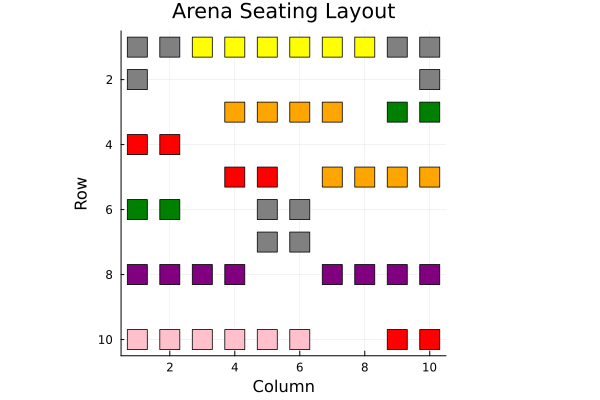

In [2]:
using Plots

# Create visualization of the solution
function visualize_seating(model)
    # Get solution values
    solution_matrix = fill("", 10, 10)

    # Fill matrix with group assignments
    for r in 1:10, c in 1:10
        for g in groups
            if value(model[:x][g,r,c]) > 0.5  # Using 0.5 to handle floating point
                solution_matrix[r,c] = g
            end
        end
    end

    # Create color mapping for groups
    color_map = Dict(
        "" => :white,  # Empty seats
        "a" => :blue,
        "b" => :green,
        "c" => :red,
        "d" => :purple,
        "e" => :orange,
        "f" => :yellow,
        "g" => :pink
    )

    # Mark blocked seats
    for (r,c) in blocked_seats
        solution_matrix[r,c] = ""  # Empty string for blocked seats
    end

    # Create plot
    p = plot(
        aspect_ratio=:equal,
        xlims=(0.5,10.5),
        ylims=(0.5,10.5),
        yflip=true,  # Flip y-axis to match traditional seating layout
        legend=:outerright
    )

    # Plot seats
    for r in 1:10, c in 1:10
        group = solution_matrix[r,c]
        if group != ""
            group_length = req_seats[group]
            for i in 1:group_length
                if c+i-1 <= 10
                    println("Group $group in $r,$(c+i-1)")
                    scatter!([c+i-1], [r],
                            color=color_map[group],
                            label=nothing,
                            markersize=10,
                            markershape=:square)
                end
            end
        else
            # Plot empty or blocked seats
            is_blocked = (r,c) in blocked_seats
            if is_blocked
                println("Blocked seat in $r,$c")
                scatter!([c], [r],
                        color=is_blocked ? :gray : :white,
                        markersize=10,
                        markershape=:square,
                        label= nothing)
            end
        end
    end

    title!("Arena Seating Layout")
    xlabel!("Column")
    ylabel!("Row")

    return p
end

# Display the visualization
p = visualize_seating(arena_model)
display(p)

If you encounter any difficulties ad cannot solve the problem, please
document your issues here:

In [4]:
#=



=#

# 2. Maximize the number of seats in use

Now let’s explore a different optimization objective! Instead of
focusing on revenue, imagine you’re trying to accommodate as many people
as possible at your venue - perhaps for a community event where
maximizing attendance is more important than maximizing profit.

> **Tip**
>
> Think about how this changes your objective function. What matters now
> is not the score per group, but how many seats each group occupies!

Try implementing this new objective while keeping all the safety
constraints in place.

In [5]:
# YOUR CODE BELOW

Check if your solution is correct by visualizing it with the
`visualize_seating` function below.

How many seats more are in use when compared to the previous solution?
Write a short code that calculates and prints the difference.

In [7]:
# YOUR CODE BELOW

------------------------------------------------------------------------

# Solutions

You will likely find solutions to most exercises online. However, I
strongly encourage you to work on these exercises independently without
searching explicitly for the exact answers to the exercises.
Understanding someone else’s solution is very different from developing
your own. Use the lecture notes and try to solve the exercises on your
own. This approach will significantly enhance your learning and
problem-solving skills.

Remember, the goal is not just to complete the exercises, but to
understand the concepts and improve your programming abilities. If you
encounter difficulties, review the lecture materials, experiment with
different approaches, and don’t hesitate to ask for clarification during
class discussions.

Later, you will find the solutions to these exercises online in the
associated GitHub repository, but we will also quickly go over them in
next week’s tutorial. To access the solutions, click on the Github
button on the lower right and search for the folder with today’s lecture
and tutorial. Alternatively, you can ask ChatGPT or Claude to explain
them to you. But please remember, the goal is not just to complete the
exercises, but to understand the concepts and improve your programming
abilities.